# Model Evaluation & Artifacts Generation
## Evaluate model metrics & Create artiacts for trained models  

In [2]:
import os
import sagemaker
import logging
import boto3
import time
import pandas as pd
import json
import botocore
from botocore.exceptions import ClientError


# ========================== low-level service client of the boto3 session ==========================
config = botocore.config.Config(user_agent_extra='bedissj-1699438736259')


sm = boto3.client(service_name='sagemaker', 
                  config=config)

sm_runtime = boto3.client('sagemaker-runtime',
                          config=config)

sess = sagemaker.Session(sagemaker_client=sm,
                         sagemaker_runtime_client=sm_runtime)

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## 1. Evaluate & Register models custom `SKLearn` Models
### 1.1 Configure model evaluation as a SageMaker Processing Job

#### 1.1.1 Configure Processing Parameters

In [3]:
# ========================== Processing parameters ==========================
FRAMEWORK_VERSION = '1.2-1'
instance_type = 'ml.t3.medium'
instance_count = 1

model_s3_uri = 's3://{}/sagemaker-scikit-lea-240604-1642-002-59cbda6b/output/'.format(bucket)
test_data_s3_uri = 's3://{}/sagemaker-scikit-learn-2024-03-06-21-05-51-569/output/bank-churn-test/'.format(bucket)


#### 1.1.2 Configure Pocessing Inputs & Outputs

In [5]:
from sagemaker.processing import ProcessingInput, ProcessingOutput


input_model = '/opt/ml/processing/input/model'
input_data = '/opt/ml/processing/input/data'
output_data = '/opt/ml/processing/output'


# ========================== Processing inputs ==========================
processing_inputs = [
    #### Trained model ####
    ProcessingInput(input_name= 'model',
                    source=model_s3_uri,
                    destination=input_model),
    
    #### Test subset ####
    ProcessingInput(input_name='testSubset',
                    source=test_data_s3_uri,
                    destination=input_data)
]


# ========================== Processing outputs ==========================
processing_outputs = [
    ProcessingOutput(output_name='metrics',
                     source=output_data,
                     s3_upload_mode='EndOfJob')

]


# ========================== Processing arguments ==========================
processing_args=[
    '--input-model', str(input_model),
    '--input-data', str(input_data),
    '--output-data', str(output_data)
]


#### 1.1.3 Instanciate `SKLearn` Processor

In [37]:
from sagemaker.sklearn.processing import SKLearnProcessor


evaluation_processor = SKLearnProcessor(
    framework_version=FRAMEWORK_VERSION,
    instance_type=instance_type,
    instance_count=instance_count,
    env={'AWS_DEFAULT_REGION': region},
    role=role,
)


INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


#### 1.1.4 Run processor to perform model evaluation

In [38]:
evaluation_processor.run(
    code='src/evaluate_metrics.py',
    inputs=processing_inputs,
    outputs=processing_outputs,
    arguments=processing_args,
    wait=False
)


INFO:sagemaker:Creating processing-job with name sagemaker-scikit-learn-2024-06-18-10-12-35-979


#### 1.1.5 Review Processing Job

In [46]:
from pprint import pprint


pprint(evaluation_processor.latest_job.describe(), compact=True)

{'AppSpecification': {'ContainerArguments': ['--input-model',
                                             '/opt/ml/processing/input/model',
                                             '--input-data',
                                             '/opt/ml/processing/input/data',
                                             '--output-data',
                                             '/opt/ml/processing/output'],
                      'ContainerEntrypoint': ['python3',
                                              '/opt/ml/processing/input/code/evaluate_metrics.py'],
                      'ImageUri': '659782779980.dkr.ecr.eu-west-3.amazonaws.com/sagemaker-scikit-learn:1.2-1-cpu-py3'},
 'CreationTime': datetime.datetime(2024, 6, 18, 10, 12, 36, 441000, tzinfo=tzlocal()),
 'Environment': {'AWS_DEFAULT_REGION': 'eu-west-3'},
 'LastModifiedTime': datetime.datetime(2024, 6, 18, 10, 29, 4, 127000, tzinfo=tzlocal()),
 'ProcessingEndTime': datetime.datetime(2024, 6, 18, 10, 29, 3, 699000, tzin

#### 1.1.6 Review model metrics

In [64]:
fig_name = 'confusion_roc_auc.png'
dic_name = 'evaluation.json'

metrics_s3_uri = evaluation_processor.latest_job.outputs[0].destination
metrics_jpg_s3_uri = os.path.join(metrics_s3_uri, fig_name)
metrics_dic_s3_uri = os.path.join(metrics_s3_uri, dic_name)

print(metrics_jpg_s3_uri)
print(metrics_dic_s3_uri)

s3://sagemaker-eu-west-3-668303144976/sagemaker-scikit-learn-2024-06-18-08-06-26-380/output/metrics/confusion_roc_auc.png
s3://sagemaker-eu-west-3-668303144976/sagemaker-scikit-learn-2024-06-18-08-06-26-380/output/metrics/evaluation.json


In [69]:
!aws s3 cp 's3://sagemaker-eu-west-3-668303144976/sagemaker-scikit-learn-2024-06-18-08-06-26-380/output/metrics/metrics/confusion_roc_auc.png' './metrics/confusion.jpg'

download: s3://sagemaker-eu-west-3-668303144976/sagemaker-scikit-learn-2024-06-18-08-06-26-380/output/metrics/metrics/confusion_roc_auc.png to metrics/confusion.jpg


In [71]:
!aws s3 cp 's3://sagemaker-eu-west-3-668303144976/sagemaker-scikit-learn-2024-06-18-08-06-26-380/output/metrics/metrics/confusion_roc_auc.png' './metrics/eval.json'

download: s3://sagemaker-eu-west-3-668303144976/sagemaker-scikit-learn-2024-06-18-08-06-26-380/output/metrics/metrics/confusion_roc_auc.png to metrics/eval.json


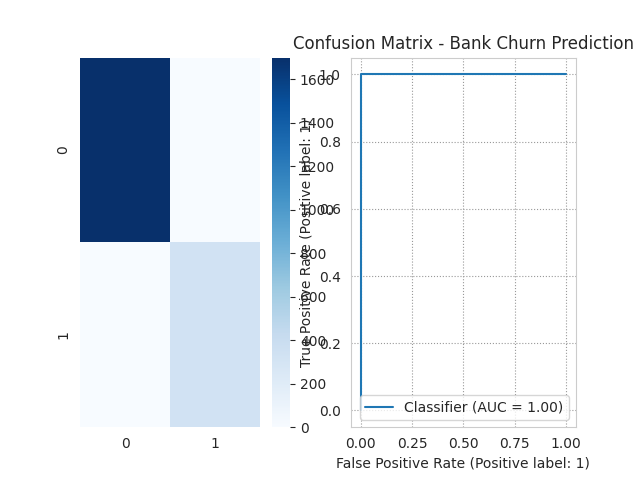

In [72]:
from IPython.display import Image

Image("metrics/confusion.jpg")

### 1.2 Register model to prepare for inference

In [ ]:
from sagemaker.sklearn.model import SKLearnModel


PY_VERSION= '3.10.6'

sklearn_model = SKLearnModel(
    entry_point='inference.py',
    model_data=model_s3_uri,
    framework_version=FRAMEWORK_VERSION,
    py_version=PY_VERSION,
    role=role,  
) 


In [ ]:
sklearn_model.register(
    
)

In [32]:
import sys

sys.version

'3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:36:39) [GCC 10.4.0]'